In [1]:
import re
from itertools import chain
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
%matplotlib inline

In [2]:
d_hashtag = pd.read_csv("../data/hashtag/Tweet hashtags - clean.csv")
d_hashtag = d_hashtag[~d_hashtag.label_full.isna()]
d_hashtag.label_full = d_hashtag.label_full.astype(int)

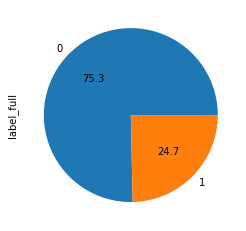

In [3]:
d_hashtag.label_full.value_counts().plot.pie(autopct='%1.1f')
plt.savefig("../data/figures/hashtag_label.png")

In [4]:
d_hashtag = d_hashtag.sort_values(by='label_full')
d_hashtag = d_hashtag.sample(frac=1)
d_hashtag.reset_index(drop=True, inplace=True)

In [7]:
d_hashtag.columns = ["hashtag", "frequency", "label"]

In [8]:
d_hashtag.head()

,hashtag,frequency,label
0,Kehamilan,43,0
1,KamiDukungOmnibusLaw,96,1
2,BUMNLokomotifNormalBaru,106,1
3,BudayaNusantara,120,0
4,BersamaPerjuangkanKhilafah,35,1


## modeling

In [9]:
def is_ascii(text):
    try:
        text.encode('ascii')
        return True
    except UnicodeEncodeError:
        return False

In [10]:
# remove non-ascii
d_hashtag['is_ascii'] = d_hashtag.hashtag.apply(is_ascii)
d_hashtag = d_hashtag[d_hashtag.is_ascii]

In [11]:
d_hashtag['hashtag_sep'] = d_hashtag.hashtag.apply(lambda x: re.sub(r"\B([A-Z])", r" \1", x))

save hashtag for 81_hashtag_wordpiece

In [12]:
hashtag_text = " ".join(d_hashtag.hashtag_sep.str.lower().to_list())
with open("../data/tokenizers/hashtag_raw.txt", "w") as f:
    f.write(hashtag_text)

## Model Single Character

In [ ]:
d_hashtag.reset_index(drop=True, inplace=True)
text = "".join(d_hashtag.hashtag.to_list())
text = sorted(list(set(text)))

### Char2Matrix Transformation

In [ ]:
def matrix_placement(row):
    index = row.name
    for c in row.hashtag:
        try:
            X[index, char2idx[c]] += 1
        except:
            X[index, char2idx[0]] += 1

In [ ]:
char2idx = dict([(char, idx) for idx, char in enumerate(text, 1)])
idx2char = dict([(idx, char) for idx, char in enumerate(text, 1)])
char2idx['UNK'] = 0
idx2char[0] = 'UNK'

X = np.zeros((d_hashtag.shape[0], len(char2idx)))

d_hashtag.loc[:, :].apply(matrix_placement, axis = 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, d_hashtag.label)

### Naive Bayes

In [52]:
def model_mnb(X_train, X_test, y_train, y_test):
    model = BernoulliNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

### Support Vector Machine

In [53]:
def model_svm(X_train, X_test, y_train, y_test):
    model = SVC(gamma='scale')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

### Random Forest

In [54]:
def model_rfc(X_train, X_test, y_train, y_test):
    model = RandomForestClassifier(n_estimators=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

### AdaBoostClassifier

In [55]:
def model_adaboost(X_train, X_test, y_train, y_test):
    model = AdaBoostClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

### Gradient Boosting

In [56]:
def model_gbc(X_train, X_test, y_train, y_test):
    model = GradientBoostingClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

## Model Triple Character

In [13]:
d_hashtag['hashtag_lower'] = d_hashtag.hashtag.str.lower()

In [14]:
d_hashtag = d_hashtag[d_hashtag.hashtag_lower.str.len() > 3]

In [16]:
d_hashtag.reset_index(drop=True, inplace=True)

In [17]:
def trigram(x):
    start = 0
    end = 3
    iterate = len(x) - 2
    token = []
    for _ in range(iterate):
        token.append(x[start:end])
        start += 1
        end += 1
        
    return token

In [18]:
d_hashtag.loc[:, 'trigram'] = d_hashtag.hashtag_lower.apply(trigram)

In [30]:
tokens = list(list(chain(*d_hashtag.trigram.tolist())))

In [31]:
tri2idx = dict((char, idx) for idx, char in enumerate(token))
idx2char = dict((idx, char) for idx, char in enumerate(token))

In [33]:
X = np.zeros((d_hashtag.shape[0], len(token)))

In [39]:
for idx in range(d_hashtag.shape[0]):
    trigram_token = d_hashtag.loc[idx, "trigram"]
    for token in trigram_token:
        X[idx, tri2idx[token]] += 1

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, d_hashtag.label)

In [46]:
X_train.shape, X_test.shape

((3653, 5563), (1218, 5563))

In [49]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1]), array([2719,  934], dtype=int64)),
 (array([0, 1]), array([924, 294], dtype=int64)))

In [57]:
model_mnb(X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       924
           1       0.75      0.62      0.68       294

    accuracy                           0.86      1218
   macro avg       0.82      0.78      0.79      1218
weighted avg       0.85      0.86      0.85      1218



In [59]:
model_svm(X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.88      0.95      0.91       924
           1       0.77      0.58      0.66       294

    accuracy                           0.86      1218
   macro avg       0.82      0.76      0.79      1218
weighted avg       0.85      0.86      0.85      1218



In [61]:
model_rfc(X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       924
           1       0.77      0.56      0.65       294

    accuracy                           0.85      1218
   macro avg       0.82      0.76      0.78      1218
weighted avg       0.85      0.85      0.85      1218



In [62]:
model_adaboost(X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       924
           1       0.74      0.51      0.61       294

    accuracy                           0.84      1218
   macro avg       0.80      0.73      0.75      1218
weighted avg       0.83      0.84      0.83      1218



In [63]:
model_gbc(X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.85      0.97      0.91       924
           1       0.82      0.47      0.60       294

    accuracy                           0.85      1218
   macro avg       0.84      0.72      0.75      1218
weighted avg       0.84      0.85      0.83      1218

